# Missing Data Imputation

**Why do we care about missing data?**
- They are inevitable in data collection 
- Some models can handle missing data (e.g. XGBoost) but some don't (e.g. linear regression)
- We need to handle missing data: 1) remove an entire observation that contains missing value, 2) remove entire variable if there is any missing value, 3) replace missing value with some estimation 
- Usually we do not want to remove data even if some fields are missing becuase the rest of fields can still be informative
- So, we need to find a way to impute (replace with some estimation) missing data 


**What are the options?**

1. Univariate methods 
    - Numerical: mean, median, arbitrary value out of distribution
    - categorical: mode (most frequent category), arbitrary value ("missing" category)
    - Both: random value
2. Multi-variable methods 
    - KNN
    - Regression
3. Adding missing indicator 
    - adding 'variable_NA' for each variable with missing data

**What is the best missing data imputation method?**
- It depends on the dataset
- We need to use cross validation to find the best approach

# Load data

In [1]:
import pandas as pd
import numpy as np

# prep dataset 
from sklearn.model_selection import train_test_split

# imputer
from sklearn.impute import SimpleImputer, KNNImputer

# feature scaling, encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# putting together in pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

# plot for comparison 
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('../data/house_price/train.csv', index_col='Id')

In [3]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
# categorical vs. numerical columns 
cat_cols = df.select_dtypes('object').columns
num_cols = df.drop('SalePrice', axis=1).select_dtypes('number').columns

print(f"Number of categorical columns: {len(cat_cols)}")
print(f"Number of numerical columns: {len(num_cols)}")

Number of categorical columns: 43
Number of numerical columns: 36


# Split data 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis=1), 
                                                    df['SalePrice'], 
                                                    test_size=0.3, 
                                                    random_state=0)

X_train.shape, X_test.shape

((1022, 79), (438, 79))

In [6]:
cat_cols_with_na = cat_cols[X_train[cat_cols].isna().mean() > 0]
num_cols_with_na = num_cols[X_train[num_cols].isna().mean() > 0]

print(f"* categorical columns that have NaN's ({len(cat_cols_with_na)}): \n{cat_cols_with_na}\n\n")
print(f"* numerical columns that have NaN's ({len(num_cols_with_na)}): \n{num_cols_with_na}")

* categorical columns that have NaN's (16): 
Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


* numerical columns that have NaN's (3): 
Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')


In [7]:
X_train[cat_cols_with_na].isna().mean().sort_values(ascending=False)

PoolQC          0.997065
MiscFeature     0.956947
Alley           0.939335
Fence           0.813112
FireplaceQu     0.467710
GarageCond      0.052838
GarageQual      0.052838
GarageFinish    0.052838
GarageType      0.052838
BsmtFinType2    0.024462
BsmtFinType1    0.023483
BsmtExposure    0.023483
BsmtCond        0.023483
BsmtQual        0.023483
MasVnrType      0.004892
Electrical      0.000978
dtype: float64

In [8]:
X_train[num_cols_with_na].isna().mean().sort_values(ascending=False)

LotFrontage    0.184932
GarageYrBlt    0.052838
MasVnrArea     0.004892
dtype: float64

# Univariate Imputation

In [9]:
X_train[num_cols_with_na].head()

,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
65,NaN,573.0,1998.0
683,NaN,0.0,1996.0
961,50.0,0.0,NaN
1385,60.0,0.0,1939.0
1101,60.0,0.0,1930.0


## Mean/median

In [10]:
# initialize imputer. use strategy='median' for median imputation
imputer = SimpleImputer(strategy='mean')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_mean_impute = imputer.transform(X_train[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_mean_impute = pd.DataFrame(X_train_mean_impute, columns=num_cols_with_na)

In [11]:
# check statistics
print("Imputer statistics (mean values):")
print(imputer.statistics_)

Imputer statistics (mean values):
[  69.66866747  103.55358899 1978.01239669]


In [12]:
X_train_mean_impute.head()

,LotFrontage,MasVnrArea,GarageYrBlt
0,69.668667,573.0,1998.000000
1,69.668667,0.0,1996.000000
2,50.000000,0.0,1978.012397
3,60.000000,0.0,1939.000000
4,60.000000,0.0,1930.000000


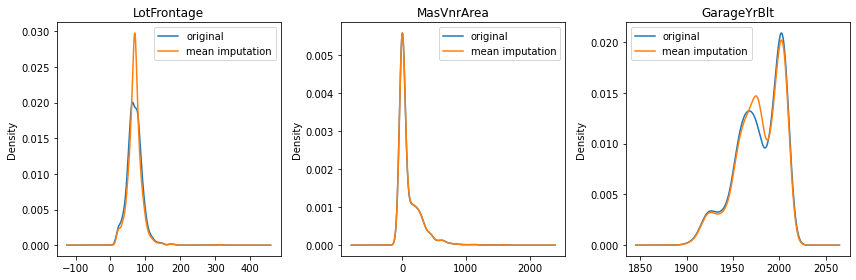

In [13]:
fig, axes = plt.subplots(figsize=(12, 4))
for i in range(len(num_cols_with_na)):
    ax = plt.subplot(1, 3, i+1)
    col = num_cols_with_na[i]
    
    X_train[col].plot.kde()
    X_train_mean_impute[col].plot.kde()
    
    ax.set_title(col)
    ax.legend(['original', 'mean imputation'])
plt.tight_layout()

## Mode (most frequent category)

In [14]:
# initialize imputer 
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[cat_cols_with_na])

# transform the data using the fitted imputer
X_train_mode_impute = imputer.transform(X_train[cat_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_mode_impute = pd.DataFrame(X_train_mode_impute, columns=cat_cols_with_na)

In [15]:
# check statistics
print("Imputer statistics (mean values):")
print(imputer.statistics_)

Imputer statistics (mean values):
['Pave' 'None' 'TA' 'TA' 'No' 'Unf' 'Unf' 'SBrkr' 'Gd' 'Attchd' 'Unf' 'TA'
 'TA' 'Gd' 'MnPrv' 'Shed']


In [16]:
X_train[cat_cols_with_na].mode()

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,Pave,None,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed


In [17]:
X_train_mode_impute.head()

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,Pave,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,Gd,Attchd,RFn,TA,TA,Gd,GdPrv,Shed
1,Pave,None,Gd,TA,Mn,GLQ,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
2,Pave,None,TA,TA,Gd,BLQ,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
3,Pave,None,TA,TA,Mn,Rec,Unf,SBrkr,Gd,Detchd,Unf,TA,TA,Gd,MnPrv,Shed
4,Pave,None,TA,Fa,No,Rec,Unf,FuseF,Gd,Detchd,Unf,TA,TA,Gd,MnPrv,Shed


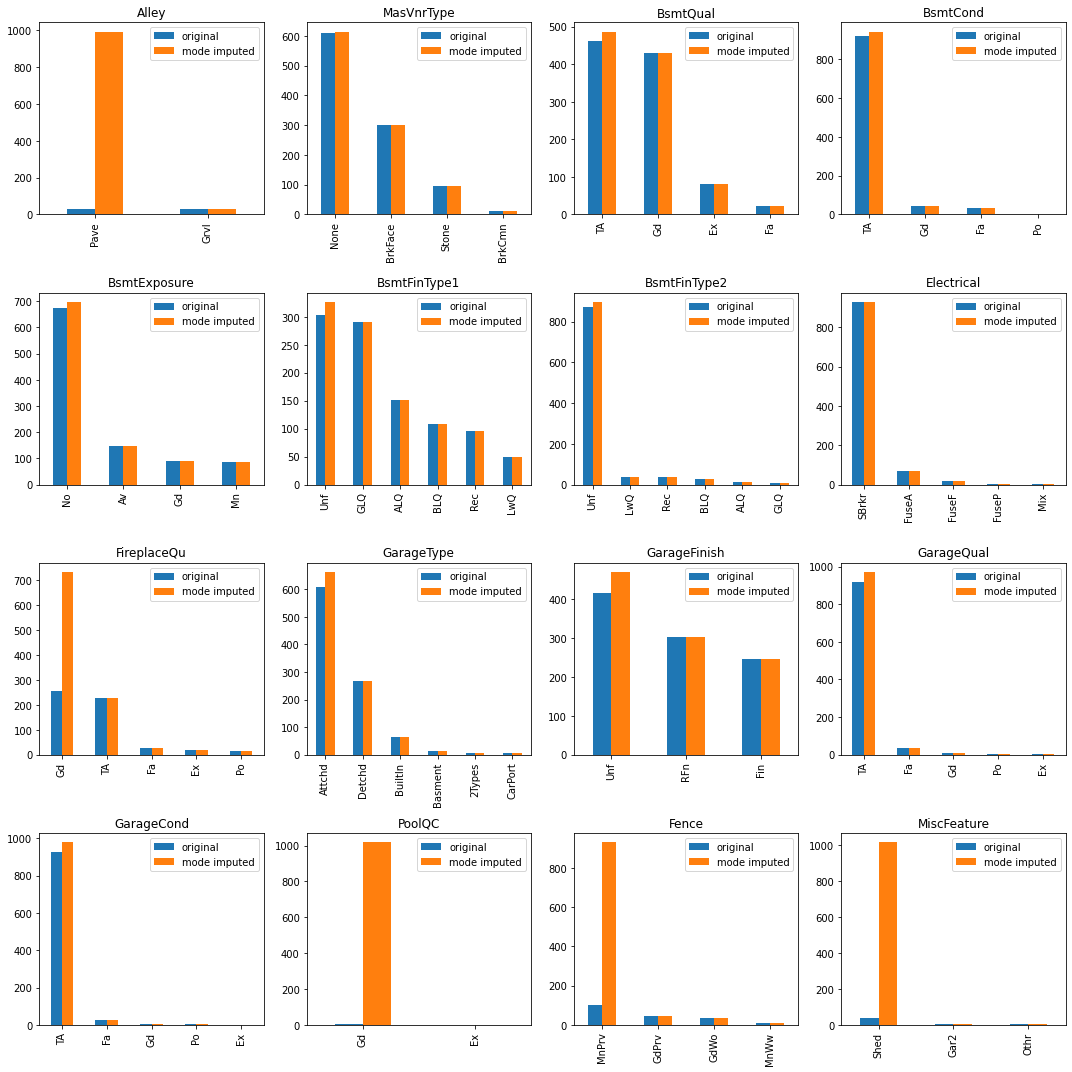

In [18]:
fig, axes = plt.subplots(4,4, figsize=(15, 15))

for i in range(len(cat_cols_with_na)):
    col_name = cat_cols_with_na[i]
    original = X_train[col_name].value_counts()
    imputed = X_train_mode_impute[col_name].value_counts()
    combined = pd.concat([original, imputed], keys=['original', 'mode imputed'], axis=1)

    ax = axes[i//4, i%4]
    combined.plot.bar(ax=ax)
    ax.set_title(col_name)
    
plt.tight_layout()

##  Categorical: 'Missing' category

In [19]:
# initialize imputer 
imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[cat_cols_with_na])

# transform the data using the fitted imputer
X_train_missing_impute = imputer.transform(X_train[cat_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_missing_impute = pd.DataFrame(X_train_mode_impute, columns=cat_cols_with_na)

In [20]:
X_train_missing_impute.head()

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,Pave,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,Gd,Attchd,RFn,TA,TA,Gd,GdPrv,Shed
1,Pave,None,Gd,TA,Mn,GLQ,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
2,Pave,None,TA,TA,Gd,BLQ,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
3,Pave,None,TA,TA,Mn,Rec,Unf,SBrkr,Gd,Detchd,Unf,TA,TA,Gd,MnPrv,Shed
4,Pave,None,TA,Fa,No,Rec,Unf,FuseF,Gd,Detchd,Unf,TA,TA,Gd,MnPrv,Shed


## Random

# Multivariate Imputation

In [21]:
# initialize imputer 
imputer = KNNImputer()

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_knn_impute = imputer.transform(X_train[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute = pd.DataFrame(X_train_knn_impute, columns=num_cols_with_na)

In [22]:
X_train_knn_impute.head()

,LotFrontage,MasVnrArea,GarageYrBlt
0,71.6,573.0,1998.0
1,56.2,0.0,1996.0
2,50.0,0.0,1979.2
3,60.0,0.0,1939.0
4,60.0,0.0,1930.0


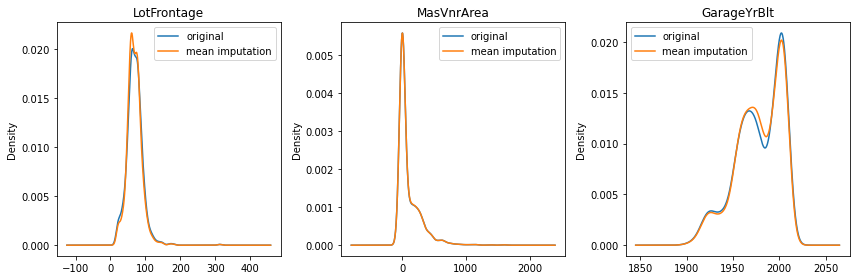

In [23]:
fig, axes = plt.subplots(figsize=(12, 4))
for i in range(len(num_cols_with_na)):
    ax = plt.subplot(1, 3, i+1)
    col = num_cols_with_na[i]
    
    X_train[col].plot.kde()
    X_train_knn_impute[col].plot.kde()
    
    ax.set_title(col)
    ax.legend(['original', 'mean imputation'])
plt.tight_layout()

# Adding Missing Indicator

In [24]:
num_cols_with_na.append(num_cols_with_na + '_NA')

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'LotFrontage_NA',
       'MasVnrArea_NA', 'GarageYrBlt_NA'],
      dtype='object')

In [25]:
# initialize imputer 
imputer = KNNImputer(add_indicator=True)

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(X_train[num_cols_with_na])

# transform the data using the fitted imputer
X_train_knn_impute = imputer.transform(X_train[num_cols_with_na])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute = pd.DataFrame(X_train_knn_impute, 
                                  columns=num_cols_with_na.append(num_cols_with_na + '_NA'))

In [26]:
X_train_knn_impute.head()

,LotFrontage,MasVnrArea,GarageYrBlt,LotFrontage_NA,MasVnrArea_NA,GarageYrBlt_NA
0,71.6,573.0,1998.0,1.0,0.0,0.0
1,56.2,0.0,1996.0,1.0,0.0,0.0
2,50.0,0.0,1979.2,0.0,0.0,1.0
3,60.0,0.0,1939.0,0.0,0.0,0.0
4,60.0,0.0,1930.0,0.0,0.0,0.0


# Combining transformers with estimator

So, let's say we want to fit a Lasso regression model with our data - only numeric data this time. What we would do first is the following:  

In [28]:
X_num = X_train[num_cols].copy()

# missing data imputation
imputer = SimpleImputer(strategy='mean')
X_transform = imputer.fit_transform(X_num)
X_transform = pd.DataFrame(X_transform, columns=X_num.columns)

# fit model 
lasso = Lasso()
lasso.fit(X_transform, y_train)
lasso.score(X_transform, y_train)

0.8419801028237114

This is great but we have to pass the output if the first step to the next step as an input. If we have multiple feature engineering steps, it will be confusing to handle different inputs/outputs. So, here comes Pipeline to rescue!

Pipeline is a class with wich you can put transformers and an estimator (model) together as sequential steps. You need to pass a list of tuples of steps: (step_name, transformer/estimator class)

In [29]:
pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('lasso', Lasso())])

pipe.fit(X_num, y_train)
pipe.score(X_num, y_train)

0.8419801028237114

Great! It's a lot cleaner! As you can see, Pipeline passes the first step's output to the next step as its input. So it's sequential.

# Applying different transformers to different columns

Now let's go back to our original dataset where we have both numerical and categorical variables. Can we put these things together like we just did? 

In [30]:
pipe = Pipeline([('num_imputer', SimpleImputer(strategy='mean')),
                 ('cat_imputer', SimpleImputer(strategy='most_frequent')),
                 ('lasso', Lasso())])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'RL'

No! When `pipe` fits `SimpleImputer(strategy='mean')` to X_train, which has both numerical and categorical, it fails because `SimpleImputer(strategy='mean')` can only apply to numerical variables. So, we need to let our pipeline know that we want to apply mean imputation to only numerical variables and most_frequent imputation to categorical variables. 

How do we do that? With `ColumnTransformer`! 

`ColumnTransformer` is similar to `Pipeline` in a sense that you pass a list of (step_name, transformer class) tuples, but in this time, you pass another argument in the tuple which is column names you want to apply the transformer. 

In [31]:
transformer = ColumnTransformer([('numerical', SimpleImputer(strategy='mean'), num_cols)])

# fit
X_train_transformed = transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=num_cols)

X_train_transformed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60.0,69.668667,9375.0,7.0,5.0,1997.0,1998.0,573.0,739.0,0.0,...,645.0,576.0,36.0,0.0,0.0,0.0,0.0,0.0,2.0,2009.0
1,120.0,69.668667,2887.0,6.0,5.0,1996.0,1997.0,0.0,1003.0,0.0,...,431.0,307.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2008.0
2,20.0,50.000000,7207.0,5.0,7.0,1958.0,2008.0,0.0,696.0,0.0,...,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0
3,50.0,60.000000,9060.0,6.0,5.0,1939.0,1950.0,0.0,204.0,0.0,...,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2009.0
4,30.0,60.000000,8400.0,2.0,5.0,1920.0,1950.0,0.0,290.0,0.0,...,246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2009.0


However, you may have noticed that the output columns are not the full columns of the DataFrame you passed in, it's only columns that you used for transformer.

This time, let's put both transformers together.

In [32]:
# applying different transformers to different columns 
transformer = ColumnTransformer(
    [('numerical', SimpleImputer(strategy='mean'), num_cols), 
     ('categorical', SimpleImputer(strategy='most_frequent'), cat_cols)])


transformer.fit(X_train)
X_train_transformed = transformer.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, 
                                   columns=list(num_cols) + list(cat_cols))

In [33]:
X_train_transformed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,69.6687,9375,7,5,1997,1998,573,739,0,...,Attchd,RFn,TA,TA,Y,Gd,GdPrv,Shed,WD,Normal
1,120,69.6687,2887,6,5,1996,1997,0,1003,0,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,20,50,7207,5,7,1958,2008,0,696,0,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,50,60,9060,6,5,1939,1950,0,204,0,...,Detchd,Unf,TA,TA,P,Gd,MnPrv,Shed,WD,Normal
4,30,60,8400,2,5,1920,1950,0,290,0,...,Detchd,Unf,TA,TA,N,Gd,MnPrv,Shed,WD,Normal


Now the output columns are `list(num_cols) + list(cat_cols)` which is different from the original column order. **Remember the output columns are the concatenated outputs of each step in ColumnTransformer**. 

This is still very handy that you can just use a few lines of code to perform multiple feature engineering steps.

If you have other transformers, e.g. StandardScaler, you cannot do this because the output columns are not more than X_train.

In [34]:
# applying different transformers to different columns 
transformer = ColumnTransformer(
    [('numerical', SimpleImputer(strategy='mean'), num_cols), 
     ('categorical', SimpleImputer(strategy='most_frequent'), cat_cols)])


transformer.fit(X_train)
X_train_transformed = transformer.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, 
                                   columns=list(num_cols) + list(cat_cols))

Then how do we apply multiple steps to a set of columns and a different steps to a different set of columns? 

We use `Pipeline` again!

In [35]:

num_pipeline= Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('scaler', StandardScaler())])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_pipe = ColumnTransformer([("num_pipeline", num_pipeline, num_cols),
                                 ("cat_pipeline", cat_pipeline, cat_cols)])

preprocessor_pipe.fit(X_train)
X_train_imputed = preprocessor_pipe.transform(X_train)

In [36]:
X_train_imputed

<1022x280 sparse matrix of type '<class 'numpy.float64'>'
	with 80544 stored elements in Compressed Sparse Row format>

Difference between Pipeline vs. ColumnTransformer:

Pipeline 
- passes the output of the first transformer to the next one
- Sequential
- No option to pass which columns to apply transformers
- Output will be the same shape of the original input shape
- Work with an estimator
- fit, fit_transform, fit_predict, predict, score, etc.

ColumnTransformer 
- ColumnTransformer treats each transformer independently. 
- Parallel
- Can specify which column each transformer applies to 
- Output is concatenated array, concatenated after all steps. Size will can be different from input
- The output column order will be the order of passed columns
- Only for column transformation. No prediction
- fit, fit_transform (no predict or score)


# Finding the best missing data imputation method

In [37]:
pipe = Pipeline([("preprocessor", preprocessor_pipe), ("regression", Lasso())])

In [38]:
pipe.fit(X_train, y_train)

/Users/minkyung/Dropbox/mk-personal-repo/feature-engineering/venv-feature-engineering/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1149587594.470337, tolerance: 623395084.5784423
  max_iter, tol, rng, random, positive)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFi...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 

In [39]:
pipe.score(X_train, y_train)

0.948354008029059

In [40]:
pipe.fit(X_test, y_test)
pipe.score(X_test, y_test)

/Users/minkyung/Dropbox/mk-personal-repo/feature-engineering/venv-feature-engineering/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4564032780.537415, tolerance: 297357825.11418265
  max_iter, tol, rng, random, positive)


0.964697513677464

# Finding the best imputation technique using GridSearchCV

In [41]:
param_grid = dict(preprocessor__num_pipeline__imputer__strategy=['mean', 'median'])

In [42]:
grid_search = GridSearchCV(pipe, param_grid)

In [43]:
grid_search.fit(X_train, y_train)

/Users/minkyung/Dropbox/mk-personal-repo/feature-engineering/venv-feature-engineering/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1936836939.4265137, tolerance: 500724925.9023501
  max_iter, tol, rng, random, positive)
/Users/minkyung/Dropbox/mk-personal-repo/feature-engineering/venv-feature-engineering/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3915570538.1009216, tolerance: 458893202.3544333
  max_iter, tol, rng, random, positive)
/Users/minkyung/Dropbox/mk-personal-repo/feature-engineering/venv-feature-engineering/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:515: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
      

In [44]:
grid_search.cv_results_

{'mean_fit_time': array([0.66055613, 0.66565676]),
 'std_fit_time': array([0.02522975, 0.04959523]),
 'mean_score_time': array([0.01417799, 0.0146534 ]),
 'std_score_time': array([0.00051472, 0.0003648 ]),
 'param_preprocessor__num_pipeline__imputer__strategy': masked_array(data=['mean', 'median'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'preprocessor__num_pipeline__imputer__strategy': 'mean'},
  {'preprocessor__num_pipeline__imputer__strategy': 'median'}],
 'split0_test_score': array([0.71941699, 0.71899503]),
 'split1_test_score': array([0.82655208, 0.8264986 ]),
 'split2_test_score': array([0.87279455, 0.87285573]),
 'split3_test_score': array([0.86841557, 0.86839973]),
 'split4_test_score': array([0.89531428, 0.89557656]),
 'mean_test_score': array([0.83649869, 0.83646513]),
 'std_test_score': array([0.06261375, 0.06282804]),
 'rank_test_score': array([1, 2], dtype=int32)}

In [45]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFi...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 

In [46]:
grid_search.best_params_

{'preprocessor__num_pipeline__imputer__strategy': 'mean'}

In [47]:
grid_search.refit_time_

0.8859891891479492